In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
!pip install fastai --upgrade 
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
      voila 0.5.4 OK


In [3]:
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
import gdown
from fastai.imports import *

In [4]:
#!git clone https://github.com/spMohanty/PlantVillage-Dataset


In [5]:
#cd notebooks


Import the PlantVillage dataset from its path. Here we create a path object to be used later for training. 

In [6]:
PATH_IMG = Path('PlantVillage-Dataset/raw/')

In [7]:
#batch_size = 64

Get all the images at the path 

In [8]:
fns=get_image_files(PATH_IMG)

Inspecting the images file of sick/healthy leaves of different species. We are going to built classifier that detect the 

In [9]:
fns

(#162916) [Path('PlantVillage-Dataset/raw/grayscale/Corn_(maize)___Northern_Leaf_Blight/ac42d899-17ee-4807-a822-dbb105fd88eb___RS_NLB 3965.JPG'),Path('PlantVillage-Dataset/raw/grayscale/Corn_(maize)___Northern_Leaf_Blight/2f91a397-315c-45bb-9d88-3d1389c82d98___RS_NLB 3508.JPG'),Path('PlantVillage-Dataset/raw/grayscale/Corn_(maize)___Northern_Leaf_Blight/2ea20efb-b8d6-4ff9-8e72-418fd4a239f0___RS_NLB 4022.JPG'),Path('PlantVillage-Dataset/raw/grayscale/Corn_(maize)___Northern_Leaf_Blight/3fdd99f1-a3df-4498-8b6a-b844621a72ca___RS_NLB  4670 copy.jpg'),Path('PlantVillage-Dataset/raw/grayscale/Corn_(maize)___Northern_Leaf_Blight/fdff294e-df6e-42eb-9bcf-edecf4002891___RS_NLB 4158.JPG'),Path('PlantVillage-Dataset/raw/grayscale/Corn_(maize)___Northern_Leaf_Blight/0b5eb8db-3477-488b-9cce-6a7712d895ab___RS_NLB 4232.JPG'),Path('PlantVillage-Dataset/raw/grayscale/Corn_(maize)___Northern_Leaf_Blight/07d88aa9-1c25-46c9-a48a-85db9d970905___RS_NLB 3976.JPG'),Path('PlantVillage-Dataset/raw/grayscale/Corn

In [10]:
leaf=DataBlock(blocks=(ImageBlock,CategoryBlock),
               get_items=get_image_files,
               splitter=RandomSplitter(valid_pct=(0.2),seed=42),
               get_y=parent_label,item_tfms=Resize(256))

Check number of images we have. We have 162916 images.

In [11]:
len(fns)


162916

Explore the dataset and check data loaders. We see the datasets contain different types of leaves and different augementation. 

In [12]:
dls=leaf.dataloaders(PATH_IMG,num_workers = 0,bs=64)

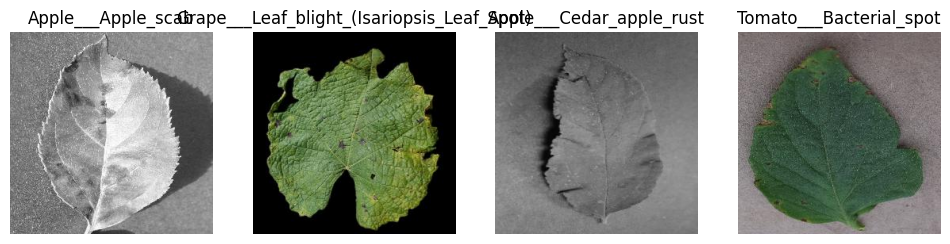

In [13]:
dls.valid.show_batch(max_n=4, nrows=1)

Then we randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways. The min_scale paramenter determines how much of the image to select at minimum each time. Also, Grayscale images simplifies the algorithm and reduces computational requirement while Color images increase the complexity of the model ,providing with unnecessary information

In [14]:
leaf = leaf.new(
    item_tfms=RandomResizedCrop(256, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = leaf.dataloaders(PATH_IMG)

Show the batch after data augmentation. These are 8 random variations of one leaf image.

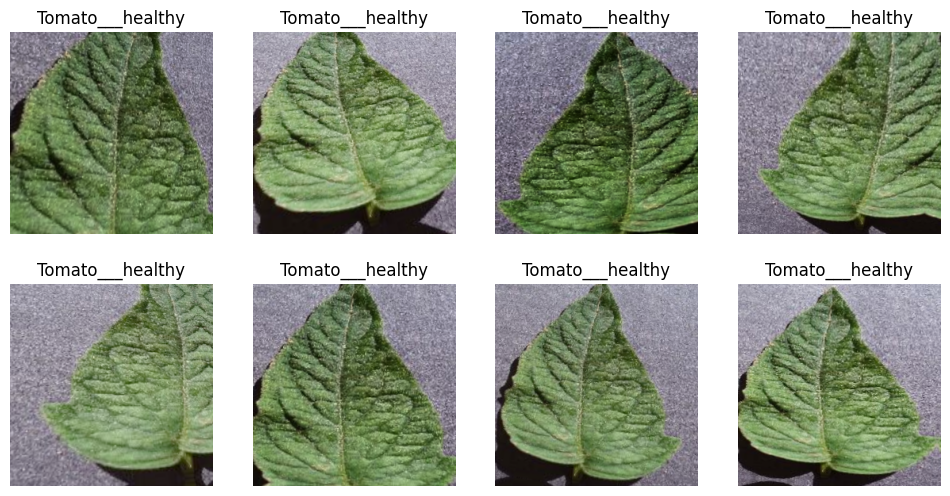

In [15]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [16]:
learn = vision_learner(dls, resnet34, metrics=[accuracy, error_rate])
learn.fine_tune(4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.353759,0.180975,0.937575,0.062425,03:53


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.153533,0.090928,0.968511,0.031489,04:51
1,0.090362,0.050869,0.982046,0.017954,04:45
2,0.046800,0.027419,0.990517,0.009483,04:43
3,0.033922,0.020389,0.993862,0.006138,04:48


Consider the results above: the classifier was trained with ResNet34 in 4 epochs and resulted in an fairly good accurracy about 99.28%. To better understand the result, we should evaluate the confusion matrix to investigate what leads to the misclassifications and if it is a potential dataset issue(or model itself).Conventionally,a confusion matrix often contains the following insights of model results:

- True Positive: You predicted positive, and it’s true.
- True Negative: You predicted negative, and it’s true.
- False Positive: (Type 1 Error): You predicted positive, and it’s false.
- False Negative: (Type 2 Error): You predicted negative, and it’s false.
- Accuracy: the proportion of the total number of correct predictions that were correct.
- Positive Predictive Value or Precision: the proportion of positive cases that were correctly identified.
- Negative Predictive Value: the proportion of negative cases that were correctly identified.
- Sensitivity or Recall: the proportion of actual positive cases which are correctly identified.
- Specificity: the proportion of actual negative cases which are correctly identified.
- Rate: It is a measuring factor in a confusion matrix. It has also 4 types TPR, FPR, TNR, and FNR.



In [17]:
interp = ClassificationInterpretation.from_learner(learn)

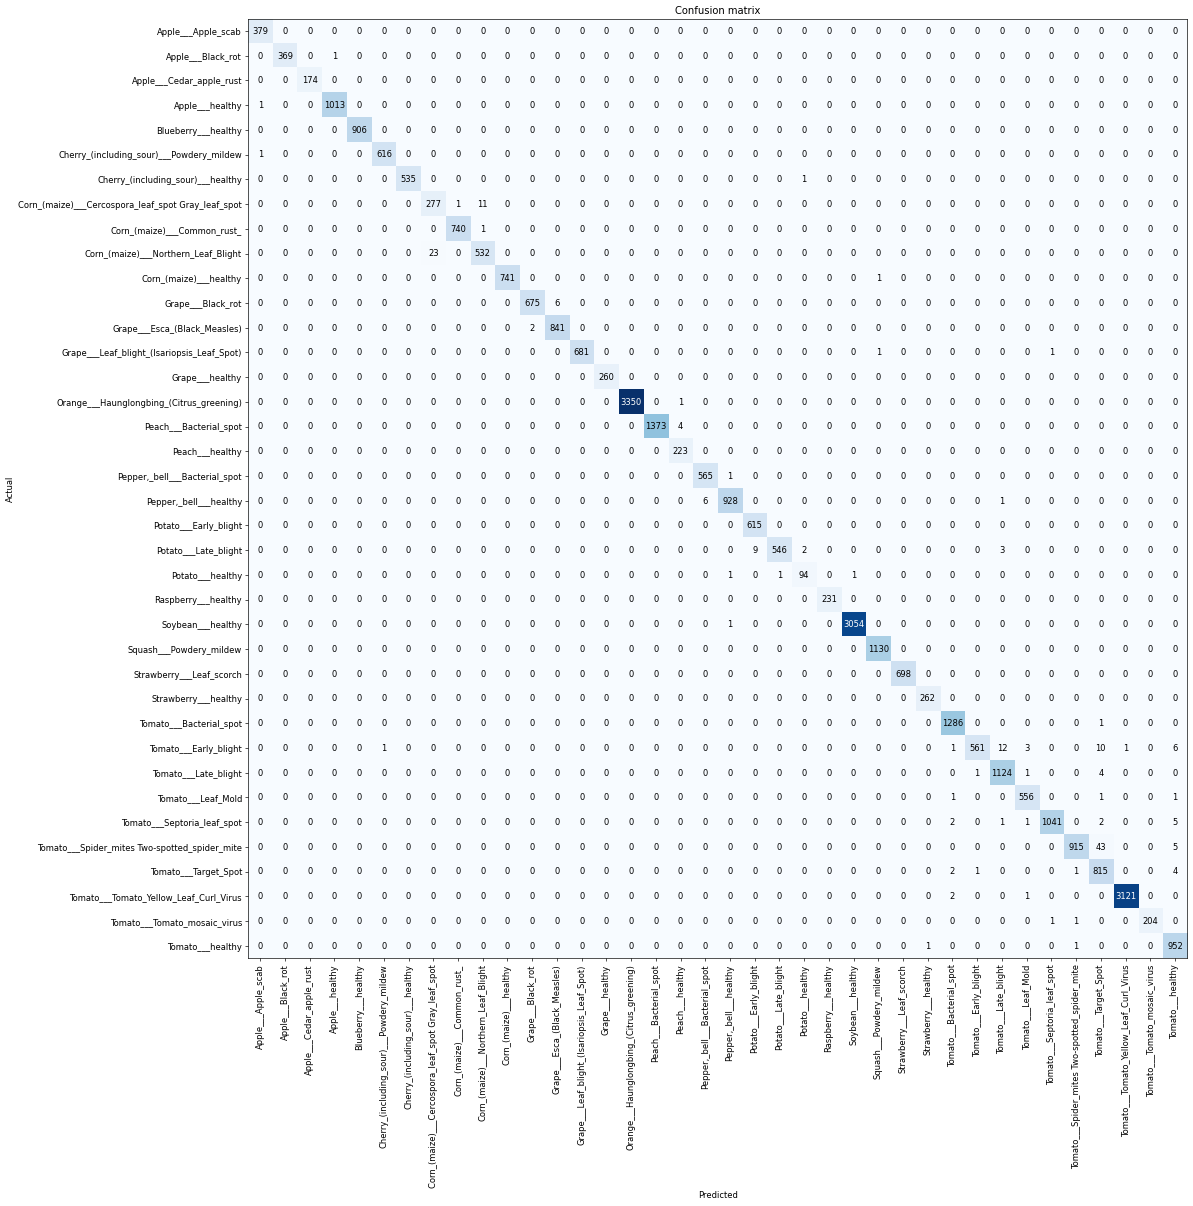

In [18]:
interp.plot_confusion_matrix(figsize=(20, 20),dpi=60)

In the matrix above, rows and columns represent the actual labels and predictions respectively.The diagonal entries of the matrix represent correctly classified images by the model. The matrix is calculated using the validation set. With the color-coding, the intuitive goal is to have white everywhere except the diagonal, where we want dark blue. It is not hard to observe that errors seem to occur around tomato leaves with spider mites and target spots. 

To justify this guessing, we can quickly check the top 5 images that have the highest loss. The output below shows that each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction

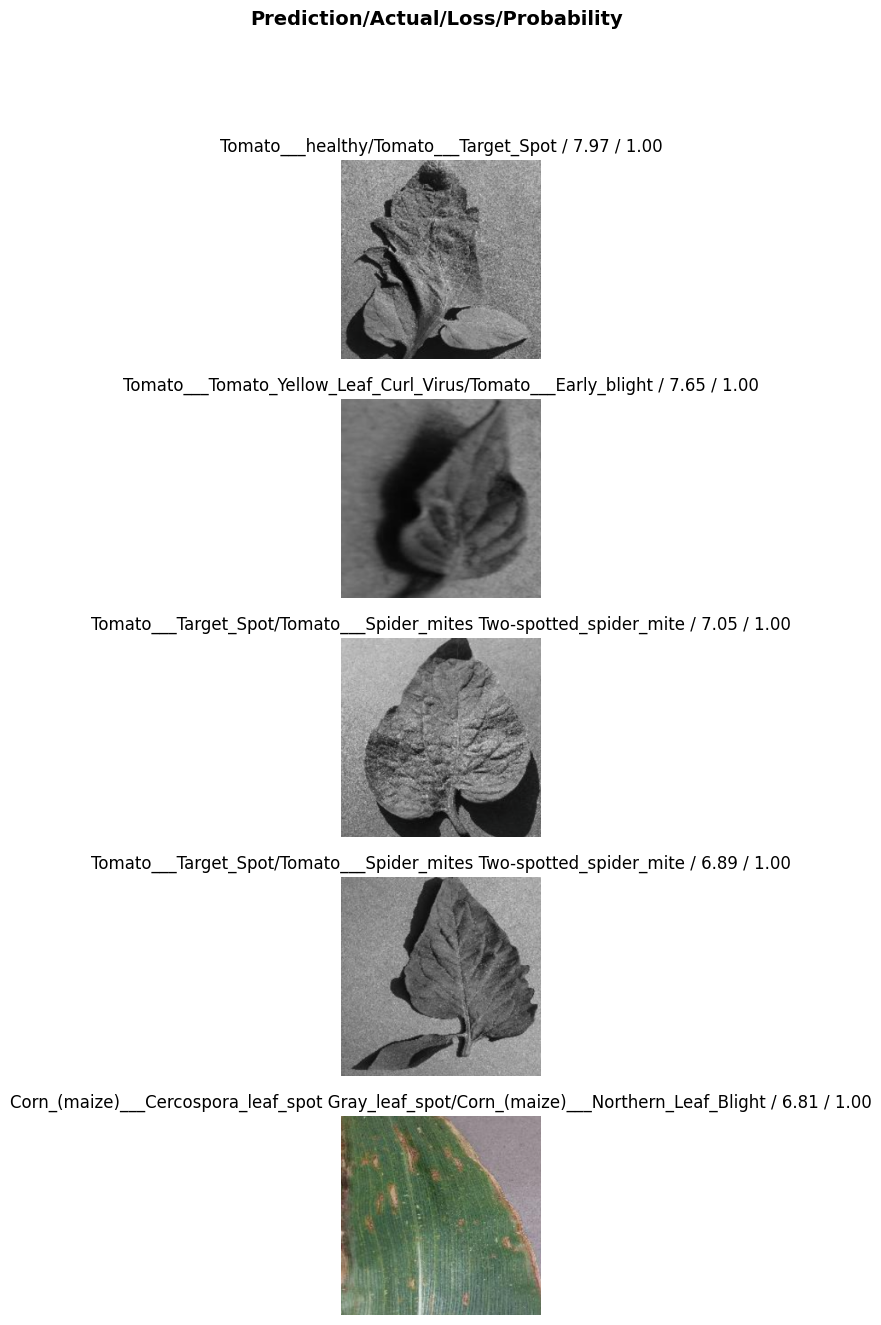

In [19]:
interp.plot_top_losses(5, nrows=5)

From these 5 images, we observe that:
- Grayscale pictures tend to make the spots of tomatos leaves less visible. It is a challenging task even for a normal pair of human eyes. The color of spots are too close to after grayscale dark/shadow color. Though grayscale picture is computationally efficient for many CV tasks, it has the tradeoff. It is worthy to keep evaluating if it is essential to use grayscale and what are the related use case from customers. If we are going to apply this model for plants in night time or places that do not have much sunlight, the design of this model might not be sufficient to fullfill the demands. 
- There is a broken crop image(I have removed it in the first round) 

So we are safe to clean out these leaves images as they are not representive as input for our use case. 

Cleaning the data by unlink broken data through interactive UI of fastai. The code can be repeatedly used for cleaning the images data. 

In [20]:
#from fastai.vision.widgets import *
#cleaner = ImageClassifierCleaner(learn)
#cleaner
#for idx in cleaner.delete(): cleaner.fns[idx].unlink()
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In addition to evaluation and cleaning, we want to evaluate the potential of improving our choice of learning rate.If the learning rate is too slow, we take more time to reach the optimum result. If it is too high, we might miss the optimum result and never reach it. We can visually find the best learning rate that achieves lowest loss through loss vs learning rate graph: 

In [21]:
# lrs_minimum,lrs_steep,lrs_valley,lrs_slide = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [22]:
# print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

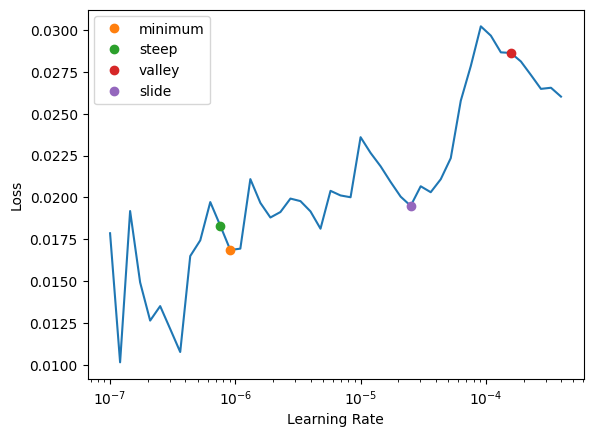

In [23]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [24]:
print(f"Minimum/10: {lrs.minimum:.2e}, steepest point: {lrs.steep:.2e}")

Minimum/10: 9.12e-08, steepest point: 7.59e-07


Save the model for future use

In [25]:
learn.save('Plant_disease_detector_4_cycles')

Path('models/Plant_disease_detector_4_cycles.pth')

Export our model as "export.pkl" by fastai for future used. ( We can also directly use the learner from above since it is just a function, but saving the model is beneficial for scalability & resuablity in the future )

In [26]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

Now, we are ready to turn this classifier to an online application. We reused the model we just trained and exported at the current directory and get access to our data loaders for the prediction classes:

In [27]:
learn_inf = load_learner(path/'export.pkl')
learn_inf.dls.vocab

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [28]:
import ipywidgets as widgets
from ipywidgets import *
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value=(), description='Upload')

Testing the upload button by faking an upload image from a directory

In [29]:
btn_upload = SimpleNamespace(data = ['PlantVillage-Dataset/raw/color/Apple___Cedar_apple_rust/04da297e-5238-41b1-a8a0-0c87c6c2f21f___FREC_C.Rust 4394.JPG'])


In [30]:
img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl
     

Output()

In [31]:
pred,pred_idx,probs = learn_inf.predict(img)

Add label below the image to show prediction outcome and its corresponding probablity:

In [32]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: Apple___Cedar_apple_rust; Probability: 1.0000')

Create button'Classify', which will classify the uploaded image from user after clicking:

In [33]:
btn_run = widgets.Button(description='Detect disease')
btn_run

Button(description='Detect disease', style=ButtonStyle())

In [34]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [35]:
btn_upload = widgets.FileUpload()

Organize buttons into a box:

In [36]:
VBox([widgets.Label('Upload plant leaves image to identify health conditions of your plant! '), 
      btn_upload, btn_run, out_pl, lbl_pred])

The application above identified apple cedar rust correctly ( and confidently with probablity = 1)!